# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from imageio import imread
from cv2 import resize as imresize
import datetime
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 25

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(no_of_frames,source_path, folder_list, batch_size,image_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,29,no_of_frames)).astype(int)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),image_size[0],image_size[1],3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = imresize(image,image_size)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255  #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255  #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if(len(folder_list)%batch_size != 0):
            for folder in range(len(folder_list)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = imresize(image,image_size)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255  #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255  #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


In [5]:
def plot_acc(history):
    plt.figure(figsize=(10,3))
    plt.subplot(121)
    plt.plot(np.around(history.history['loss'],3))   
    plt.plot(np.around(history.history['val_loss'],3))
    plt.legend(['loss','val_loss'])
    plt.subplot(122)
    plt.plot(np.around(history.history['categorical_accuracy'],3))   
    plt.plot(np.around(history.history['val_categorical_accuracy'],3))
    plt.legend(['categorical_accuracy','val_categorical_accuracy'])
    plt.tight_layout()

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

model = Sequential()

model.add(Conv3D(16, kernel_size=(3,3,3), input_shape=(15, 120, 120, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [8]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 16)  1312      
                                                                 
 batch_normalization (BatchN  (None, 15, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 15, 120, 120, 16)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 60, 60, 32)     13856     
                                                                 
 batch_normalization_1 (Batc  (None, 7, 60, 60, 32)    1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
train_generator = generator(15,train_path, train_doc, batch_size,(120,120))
val_generator = generator(15,val_path, val_doc, batch_size,(120,120))

In [10]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [11]:
batch_size = 25
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [12]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 25
Epoch 1/15
27/27 [==============================] - ETA: 0s - loss: 3.4063 - categorical_accuracy: 0.2074Source path =  Project_data/val ; batch size = 25

Epoch 1: saving model to model_init_2024-05-0704_06_02.598057\model-00001-3.40628-0.20741-1.67859-0.18000.h5
27/27 [==============================] - 165s 6s/step - loss: 3.4063 - categorical_accuracy: 0.2074 - val_loss: 1.6786 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/15
27/27 [==============================] - ETA: 0s - loss: 1.4919 - categorical_accuracy: 0.3274
Epoch 2: saving model to model_init_2024-05-0704_06_02.598057\model-00002-1.49194-0.32741-2.15842-0.21000.h5
27/27 [==============================] - 153s 6s/step - loss: 1.4919 - categorical_accuracy: 0.3274 - val_loss: 2.1584 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/15
27/27 [==============================] - ETA: 0s - loss: 1.2982 - categorical_accuracy: 0.4400
Epoch 3: saving model to mod

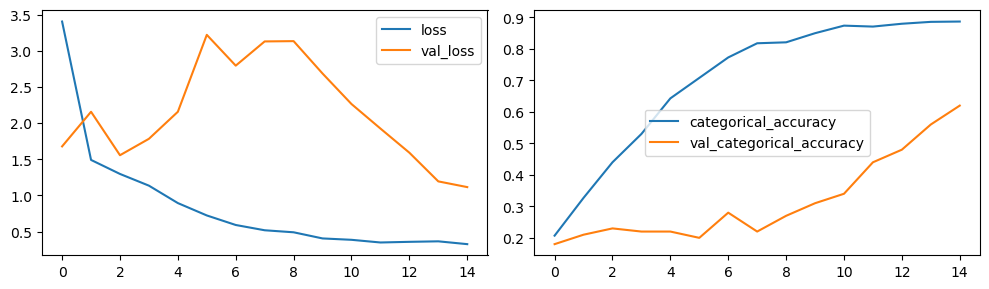

In [40]:
plot_acc(history)

**Adding more layers to tackle overfitting**
### Model1

In [13]:
model1 = Sequential()

model1.add(Conv3D(16, kernel_size=(3,3,3), input_shape=(15, 120, 120, 3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2)))

model1.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2)))

model1.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2)))

model1.add(Conv3D(128, kernel_size=(3,3,3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))

model1.add(Flatten())

model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.25))

model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.25))

#softmax layer
model1.add(Dense(5, activation='softmax'))

In [14]:
optimiser = optimizers.Adam()
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 16)  1312      
                                                                 
 batch_normalization (BatchN  (None, 15, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 15, 120, 120, 16)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 60, 60, 32)     13856     
                                                                 
 batch_normalization_1 (Batc  (None, 7, 60, 60, 32)    1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [15]:
train_generator = generator(15,train_path, train_doc, batch_size,(120,120))
val_generator = generator(15,val_path, val_doc, batch_size,(120,120))

In [16]:
model_name = 'model_1_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [17]:
batch_size = 25
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [18]:
history1 = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 25
Epoch 1/15
27/27 [==============================] - ETA: 0s - loss: 3.3414 - categorical_accuracy: 0.3259Source path =  Project_data/val ; batch size = 25

Epoch 1: saving model to model_1_init_2024-05-0704_06_02.598057\model-00001-3.34143-0.32593-1.57853-0.32000.h5
27/27 [==============================] - 142s 5s/step - loss: 3.3414 - categorical_accuracy: 0.3259 - val_loss: 1.5785 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 2/15
27/27 [==============================] - ETA: 0s - loss: 1.5246 - categorical_accuracy: 0.3719
Epoch 2: saving model to model_1_init_2024-05-0704_06_02.598057\model-00002-1.52455-0.37185-1.57420-0.27000.h5
27/27 [==============================] - 139s 5s/step - loss: 1.5246 - categorical_accuracy: 0.3719 - val_loss: 1.5742 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/15
27/27 [==============================] - ETA: 0s - loss: 1.4592 - categorical_accuracy: 0.4104
Epoch 3: saving model to

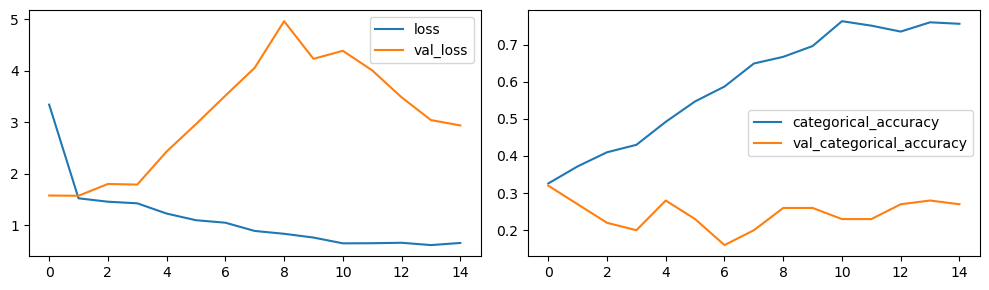

In [41]:
plot_acc(history1)

**Model has extremely overfitted, Increasing epochs to 25 and adding Batch Normalization after Dense layers to reduce overfitting**
### Model2

In [19]:
model2 = Sequential()

model2.add(Conv3D(16, kernel_size=(3,3,3), input_shape=(15, 120, 120, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))

model2.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))

model2.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))

model2.add(Conv3D(128, kernel_size=(3,3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))


model2.add(Flatten())

model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

#softmax layer
model2.add(Dense(5, activation='softmax'))

In [20]:
optimiser = optimizers.Adam()
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_7 (Conv3D)           (None, 15, 120, 120, 16)  1312      
                                                                 
 batch_normalization_7 (Batc  (None, 15, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 15, 120, 120, 16)  0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 7, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_8 (Conv3D)           (None, 7, 60, 60, 32)     13856     
                                                                 
 batch_normalization_8 (Batc  (None, 7, 60, 60, 32)   

In [21]:
train_generator = generator(15,train_path, train_doc, batch_size,(120,120))
val_generator = generator(15,val_path, val_doc, batch_size,(120,120))

In [22]:
model_name = 'model_2_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [23]:
batch_size = 25
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [24]:
history2 = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 25
Epoch 1/25
27/27 [==============================] - ETA: 0s - loss: 1.8004 - categorical_accuracy: 0.4148Source path =  Project_data/val ; batch size = 25

Epoch 1: saving model to model_2_init_2024-05-0704_06_02.598057\model-00001-1.80038-0.41481-1.74642-0.27000.h5
27/27 [==============================] - 157s 6s/step - loss: 1.8004 - categorical_accuracy: 0.4148 - val_loss: 1.7464 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/25
27/27 [==============================] - ETA: 0s - loss: 1.1558 - categorical_accuracy: 0.5852
Epoch 2: saving model to model_2_init_2024-05-0704_06_02.598057\model-00002-1.15583-0.58519-3.11677-0.16000.h5
27/27 [==============================] - 149s 6s/step - loss: 1.1558 - categorical_accuracy: 0.5852 - val_loss: 3.1168 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/25
27/27 [==============================] - ETA: 0s - loss: 0.8310 - categorical_accuracy: 0.6889
Epoch 3: saving model to

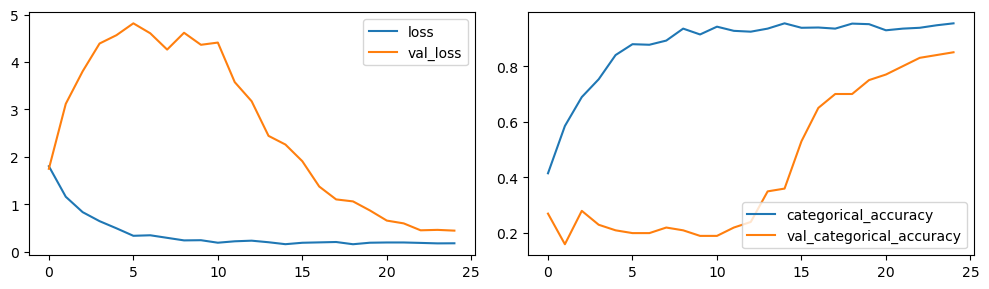

In [42]:
plot_acc(history2)

**Great improvement in performance, trying with only 10 frames instead of 15 for each video and reducing batch size to 20**<br>
**Reducing the Dropout to 0.25 from 0.5**<br>
**Gradually reducing dense connections**
### Model3

In [26]:
model3 = Sequential()

model3.add(Conv3D(16, kernel_size=(3,3,3), input_shape=(10, 120, 120, 3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

model3.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

model3.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

model3.add(Conv3D(128, kernel_size=(3,3,3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

model3.add(Flatten())

model3.add(Dense(128, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Dense(64, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

#softmax layer
model3.add(Dense(5, activation='softmax'))

In [27]:
optimiser = optimizers.Adam()
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_11 (Conv3D)          (None, 10, 120, 120, 16)  1312      
                                                                 
 batch_normalization_13 (Bat  (None, 10, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 10, 120, 120, 16)  0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 5, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_12 (Conv3D)          (None, 5, 60, 60, 32)     13856     
                                                                 
 batch_normalization_14 (Bat  (None, 5, 60, 60, 32)   

In [28]:
batch_size = 20
train_generator = generator(10,train_path, train_doc, batch_size,(120,120))
val_generator = generator(10,val_path, val_doc, batch_size,(120,120))

In [29]:
model_name = 'model_3_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [30]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [31]:
history3 = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.4902 - categorical_accuracy: 0.4309Source path =  Project_data/val ; batch size = 20

Epoch 1: saving model to model_3_init_2024-05-0704_06_02.598057\model-00001-1.49021-0.43088-2.18656-0.16000.h5
34/34 [==============================] - 118s 3s/step - loss: 1.4902 - categorical_accuracy: 0.4309 - val_loss: 2.1866 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.9383 - categorical_accuracy: 0.6324
Epoch 2: saving model to model_3_init_2024-05-0704_06_02.598057\model-00002-0.93834-0.63235-3.07938-0.23000.h5
34/34 [==============================] - 94s 3s/step - loss: 0.9383 - categorical_accuracy: 0.6324 - val_loss: 3.0794 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.6610 - categorical_accuracy: 0.7456
Epoch 3: saving model to 

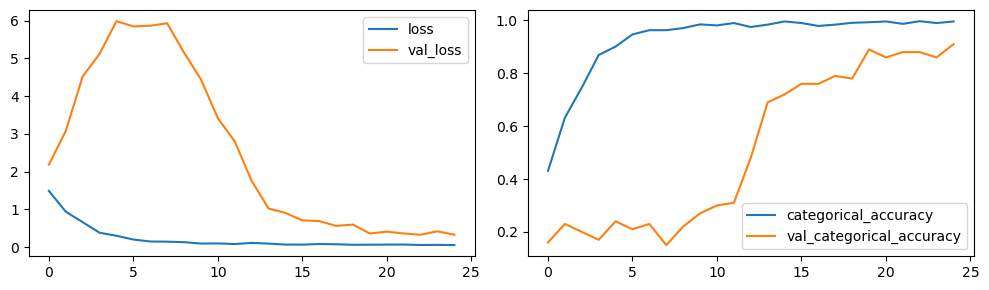

In [43]:
plot_acc(history3)

**Trying the model with increased Image size to (160,160)**
### Model4

In [33]:
model4 = Sequential()

model4.add(Conv3D(32, kernel_size=(3,3,3), input_shape=(10, 160, 160, 3), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Conv3D(128, kernel_size=(3,3,3), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))

model4.add(Flatten())

model4.add(Dense(128, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.25))

model4.add(Dense(64, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.25))

#softmax layer
model4.add(Dense(5, activation='softmax'))

In [34]:
optimiser = optimizers.Adam()
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 10, 160, 160, 32)  2624      
                                                                 
 batch_normalization_19 (Bat  (None, 10, 160, 160, 32)  128      
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 10, 160, 160, 32)  0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 5, 80, 80, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_16 (Conv3D)          (None, 5, 80, 80, 32)     27680     
                                                                 
 batch_normalization_20 (Bat  (None, 5, 80, 80, 32)   

In [35]:
batch_size = 20
train_generator = generator(10,train_path, train_doc, batch_size,(160,160))
val_generator = generator(10,val_path, val_doc, batch_size,(160,160))

In [36]:
model_name = 'model_4_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [37]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [38]:
history4 = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.5661 - categorical_accuracy: 0.4397Source path =  Project_data/val ; batch size = 20

Epoch 1: saving model to model_4_init_2024-05-0704_06_02.598057\model-00001-1.56614-0.43971-1.61203-0.30000.h5
34/34 [==============================] - 169s 5s/step - loss: 1.5661 - categorical_accuracy: 0.4397 - val_loss: 1.6120 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.0236 - categorical_accuracy: 0.6162
Epoch 2: saving model to model_4_init_2024-05-0704_06_02.598057\model-00002-1.02362-0.61618-2.36397-0.19000.h5
34/34 [==============================] - 168s 5s/step - loss: 1.0236 - categorical_accuracy: 0.6162 - val_loss: 2.3640 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.6500 - categorical_accuracy: 0.7500
Epoch 3: saving model to

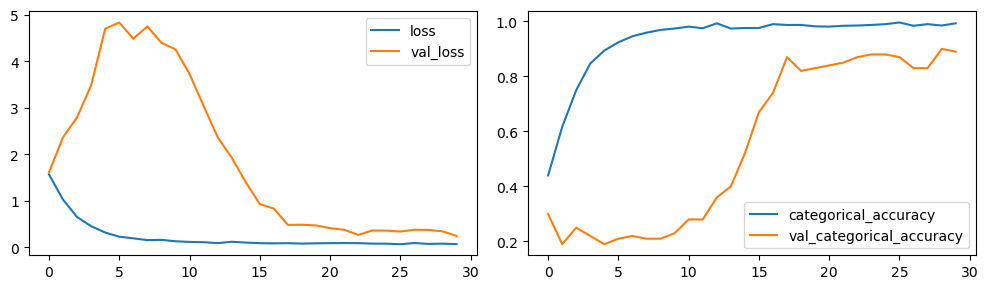

In [44]:
plot_acc(history4)

**Not any significant improvement by increasing image size, hence continuing with model 3 and reducing trainable parameters**
### Model5

In [47]:
model5 = Sequential()

model5.add(Conv3D(32, kernel_size=(3,3,3), input_shape=(10, 120, 120, 3), padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2,2,2)))

model5.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2,2,2)))

model5.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2,2,2)))

model5.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))

model5.add(Flatten())

model5.add(Dense(128, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.25))

model5.add(Dense(64, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.25))

#softmax layer
model5.add(Dense(5, activation='softmax'))

In [48]:
optimiser = optimizers.Adam()
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_23 (Conv3D)          (None, 10, 120, 120, 32)  2624      
                                                                 
 batch_normalization_31 (Bat  (None, 10, 120, 120, 32)  128      
 chNormalization)                                                
                                                                 
 activation_23 (Activation)  (None, 10, 120, 120, 32)  0         
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 5, 60, 60, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_24 (Conv3D)          (None, 5, 60, 60, 32)     27680     
                                                                 
 batch_normalization_32 (Bat  (None, 5, 60, 60, 32)   

In [49]:
batch_size = 20
train_generator = generator(10,train_path, train_doc, batch_size,(120,120))
val_generator = generator(10,val_path, val_doc, batch_size,(120,120))

In [50]:
model_name = 'model_5_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [51]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [52]:
history5 = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.4066 - categorical_accuracy: 0.4838Source path =  Project_data/val ; batch size = 20

Epoch 1: saving model to model_5_init_2024-05-0704_06_02.598057\model-00001-1.40656-0.48382-2.27224-0.28000.h5
34/34 [==============================] - 95s 3s/step - loss: 1.4066 - categorical_accuracy: 0.4838 - val_loss: 2.2722 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.7703 - categorical_accuracy: 0.6971
Epoch 2: saving model to model_5_init_2024-05-0704_06_02.598057\model-00002-0.77032-0.69706-2.63190-0.19000.h5
34/34 [==============================] - 81s 2s/step - loss: 0.7703 - categorical_accuracy: 0.6971 - val_loss: 2.6319 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.4930 - categorical_accuracy: 0.8250
Epoch 3: saving model to m

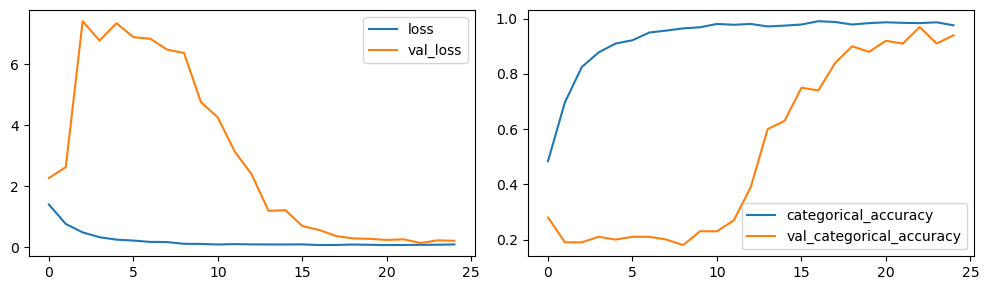

In [53]:
plot_acc(history5)

**Comparing all model metrics**

| Model Name  | Trainable Parameter | Training metrics                 | Validation metrics              |                                                                   
| :---------- | -------------------: | --------------------------------: | ------------------------------: |
| model       | 997,125             | loss: **0.3273**<br>accuracy: **0.8874** | loss: **1.1160**<br>accuracy: **0.62** |
| model1      | 1,922,661           | loss: **0.6590**<br>accuracy: **0.7556** | loss: **2.9382**<br>accuracy: **0.27** |
| model2      | 3,996,517           | loss: **0.1738**<br>accuracy: **0.9541** | loss: **0.4406**<br>accuracy: **0.85** |
| model3      | 3,987,813           | loss: **0.0531**<br>accuracy: **0.9956** | loss: **0.3284**<br>accuracy: **0.91** |
| model4      | 6,870,181           | loss: **0.0683**<br>accuracy: **0.9926** | loss: **0.2440**<br>accuracy: **0.89** |
| model5      | 2,048,997           | loss: **0.0978**<br>accuracy: **0.9765** | loss: **0.2174**<br>accuracy: **0.94** |

**Comparing validation loss and validation accuracy for all models it is found that**

### Best performing model is "model5" with 0.9765 training accuracy and 0.94 validation accuracy

**Testing a batch from validation dataset using MODEL5**

In [74]:
img_idx = np.round(np.linspace(0,29,10)).astype(int)
batch_data = np.zeros((20,len(img_idx),120,120,3))
batch_labels = np.zeros((batch_size,5))
t = np.random.permutation(val_doc)
for folder in range(20): # iterate over the batch_size
    imgs = os.listdir(val_path+'/'+ t[folder].split(';')[0])
    for idx,item in enumerate(img_idx):
        image = imread(val_path+'/'+ t[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
        image = imresize(image,(120,120))
        batch_data[folder,idx,:,:,0] = image[:,:,0]/255
        batch_data[folder,idx,:,:,1] = image[:,:,1]/255  
        batch_data[folder,idx,:,:,2] = image[:,:,2]/255
    batch_labels[folder, int(t[folder].strip().split(';')[2])] = 1

In [75]:
batch_data.shape

(20, 10, 120, 120, 3)

In [76]:
batch_labels.shape

(20, 5)

In [80]:
from keras.models import load_model
model = load_model('model_5_init_2024-05-0704_06_02.598057\model-00025-0.09784-0.97647-0.21744-0.94000.h5')

In [82]:
np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1)

1/1 [==============================] - 0s 257ms/step


array([1, 0, 1, 2, 1, 3, 1, 1, 0, 2, 1, 1, 3, 1, 1, 1, 3, 0, 3, 1],
      dtype=int64)

In [86]:
np.argmax(batch_labels,axis=1)

array([1, 0, 1, 2, 1, 3, 1, 1, 0, 2, 1, 1, 3, 1, 1, 1, 3, 0, 3, 1],
      dtype=int64)